# Open Notebook directly in Google Colab:

<a target="_blank" href="https://colab.research.google.com/github/Nicolepcx/CFEM-Seminar/blob/main/llama_3_code_interpreter_upload_dataset.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Llama 3 with code interpreting and analyzing uploaded dataset

With open-source [Code Interpreter SDK](https://github.com/e2b-dev/code-interpreter) by [E2B](https://e2b.dev/docs)

Inside this sandbox is a running Jupyter server that the LLM can use.

### Step 1: Install dependencies


In [ ]:
%pip install e2b_code_interpreter==1.0.0 python-dotenv==1.0.1 openai==1.58.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 454.3/454.3 kB 10.5 MB/s eta 0:00:00
  Attempting uninstall: openai
    Found existing installation: openai 1.59.9
    Uninstalling openai-1.59.9:
      Successfully uninstalled openai-1.59.9


### Step 2: Define API keys, prompt, and tools

Let's define our variables with API keys for Groq and E2B together with the model ID, prompt, and our tools.

In [ ]:
import os
from dotenv import load_dotenv
load_dotenv()

# TODO: Get your Nebius API key from https://studio.nebius.ai/
NEBIUS_API_KEY = os.getenv("NEBIUS_API_KEY")

# TODO: Get your E2B API key from https://e2b.dev/docs
E2B_API_KEY = os.getenv("E2B_API_KEY")

MODEL_NAME = "meta-llama/Llama-3.3-70B-Instruct-fast"

SYSTEM_PROMPT = """You're a python data scientist that is analyzing loan payments.
You are given tasks to complete and you run python code to solve them.

Information about the the temperature dataset:
- It's in the `/content/loans_payments.csv` file

Generally you follow these rules:
- the python code runs in jupyter notebook.
- every time you call `execute_python` tool, the python code is executed in a separate cell. it's okay to multiple calls to `execute_python`.
- display visualizations using matplotlib or any other visualization library directly in the notebook. don't worry about saving the visualizations to a file.
- you have access to the internet and can make api requests.
- you also have access to the filesystem and can read/write files.
- you can install any pip package (if it exists) if you need to but the usual packages for data analysis are already preinstalled.
- you can run any python code you want, everything is running in a secure sandbox environment
"""


tools = [
  {
    "type": "function",
      "function": {
        "name": "execute_python",
        "description": "Execute python code in a Jupyter notebook cell and returns any result, stdout, stderr, display_data, and error.",
        "parameters": {
          "type": "object",
          "properties": {
            "code": {
              "type": "string",
              "description": "The python code to execute in a single cell.",
            }
          },
          "required": ["code"],
        },
      },
  }
]

### Step 3: Implement the method for code interpreting

Here's the main function that use the E2B code interpreter SDK. We'll be calling this function a little bit further when we're parsing the Llama's response with tool calls.

In [ ]:
def code_interpret(e2b_code_interpreter, code):
  print("Running code interpreter...")
  exec = e2b_code_interpreter.run_code(code,
  on_stderr=lambda stderr: print("[Code Interpreter]", stderr),
  on_stdout=lambda stdout: print("[Code Interpreter]", stdout))

  if exec.error:
    print("[Code Interpreter ERROR]", exec.error)
  else:
    return exec.results

### Step 4: Implement the method for calling LLM and parsing tools

Now we're going to define and implement `chat_with_llama` method. In this method, we'll call the LLM with our `tools` dictionary, parse the output, and call our `code_interpret` method we defined above.

In [ ]:
import os
import json
import re
from openai import OpenAI

client = OpenAI(api_key=NEBIUS_API_KEY,
                base_url="https://api.studio.nebius.ai/v1/")


def chat_with_llama(e2b_code_interpreter, user_message):
  print(f"\n{'='*50}\nUser message: {user_message}\n{'='*50}")

  messages = [
      {"role": "system", "content": SYSTEM_PROMPT},
      {"role": "user", "content": user_message}
  ]

  response = client.chat.completions.create(
      model=MODEL_NAME,
      messages=messages,
      tools=tools,
      tool_choice="auto",
      max_tokens=4096,
  )

  response_message = response.choices[0].message
  tool_calls = response_message.tool_calls

  if tool_calls:
    for tool_call in tool_calls:
      function_name = tool_call.function.name
      function_args = json.loads(tool_call.function.arguments)
      if function_name == "execute_python":
        code = function_args["code"]
        code_interpreter_results = code_interpret(e2b_code_interpreter, code)
        return code_interpreter_results
      else:
        raise Exception(f"Unknown tool {function_name}")
  else:
    print(f"(No tool call in model's response) {response_message}")
    return []


### Step 5: Implement method for uploading dataset to code interpreter sandbox
The file gets uploaded to the E2B sandbox where our code interpreter is running. We get the file's remote path in the `remote_path` variable.

In [ ]:
def upload_dataset(code_interpreter):
  print("Uploading dataset to Code Interpreter sandbox...")
  file_path = "/content/loans_payments.csv"
  with open(file_path, "rb") as f:
    code_interpreter.files.write(file_path, f)
  print("Uploaded at", file_path)

### Step 6: Put everything together
In this last step, we put all the pieces together. We instantiate a new code interpreter instance using
```python
with CodeInterpreter(api_key=E2B_API_KEY) as code_interpreter:
```

and then call the `chat_with_llama` method with our user message and the `code_interpreter` instance.

Uploading dataset to Code Interpreter sandbox...
Uploaded at /content/loans_payments.csv

User message: plot a barchart of education from the file: /content/loans_payments.csv
Running code interpreter...
[Code Interpreter] college                 220
High School or Below    209
Bechalor                 67
Master or Above           4
Name: education, dtype: int64



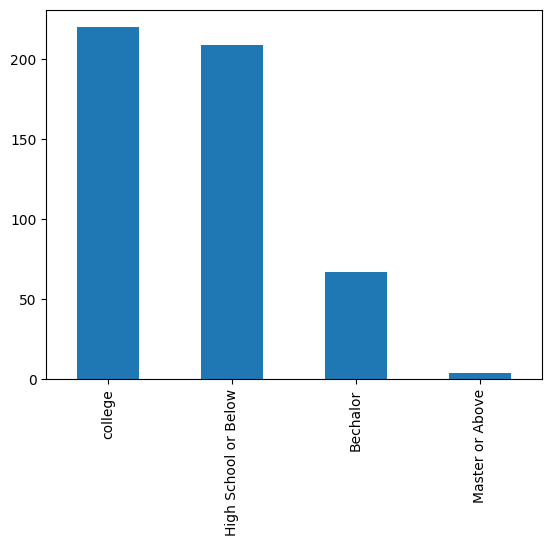

In [ ]:
from e2b_code_interpreter import Sandbox


with Sandbox(api_key=E2B_API_KEY) as code_interpreter:

  # Upload the dataset to the code interpreter sandbox
  upload_dataset(code_interpreter)

  code_results = chat_with_llama(
    code_interpreter,
    "plot a barchart of education from the file: /content/loans_payments.csv"
  )
  if code_results:
    first_result = code_results[0]
  else:
    raise Exception("No code results")


# This will render the image
# You can also access the data directly
# first_result.png
# first_result.jpg
# first_result.pdf
# ...
first_result

In [ ]:
with Sandbox(api_key=E2B_API_KEY) as code_interpreter:

  # Upload the dataset to the code interpreter sandbox
  upload_dataset(code_interpreter)

  code_results = chat_with_llama(
    code_interpreter,
    "print the first 4 rows of the file"
  )
  if code_results:
    first_result = code_results[0]
  else:
    raise Exception("No code results")


# This will render the image
# You can also access the data directly
# first_result.png
# first_result.jpg
# first_result.pdf
# ...
first_result

Uploading dataset to Code Interpreter sandbox...
Uploaded at /content/loans_payments.csv

User message: print the first 4 rows of the file 
Running code interpreter...
[Code Interpreter] /usr/local/lib/python3.10/site-packages/jupyter_client/session.py:721: UserWarning: Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant
  content = self.pack(content)



,Loan_ID,loan_status,Principal,terms,effective_date,due_date,paid_off_time,past_due_days,age,education,Gender
0,xqd20166231,PAIDOFF,1000,30,9/8/2016,10/7/2016,9/14/2016 19:31,NaN,45,High School or Below,male
1,xqd20168902,PAIDOFF,1000,30,9/8/2016,10/7/2016,10/7/2016 9:00,NaN,50,Bechalor,female
...,...,...,...,...,...,...,...,...,...,...,...
498,xqd20160499,COLLECTION_PAIDOFF,1000,30,9/12/2016,11/10/2016,11/11/2016 22:40,1.0,38,college,female
499,xqd20160500,COLLECTION_PAIDOFF,1000,30,9/12/2016,10/11/2016,10/19/2016 11:58,8.0,28,High School or Below,male


Uploading dataset to Code Interpreter sandbox...
Uploaded at /content/loans_payments.csv

User message: plot a stacked barchart of education and Gender together in one chart of /content/loans_payments.csv
Running code interpreter...


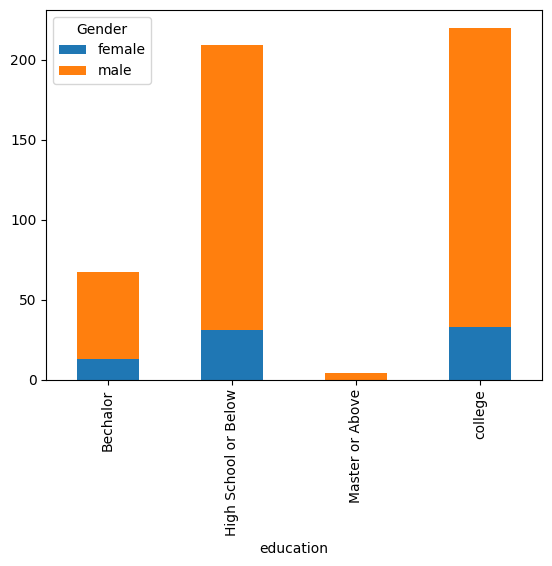

In [ ]:
with Sandbox(api_key=E2B_API_KEY) as code_interpreter:

  # Upload the dataset to the code interpreter sandbox
  upload_dataset(code_interpreter)

  code_results = chat_with_llama(
    code_interpreter,
    "plot a stacked barchart of education and Gender together in one chart of /content/loans_payments.csv"
  )
  if code_results:
    first_result = code_results[0]
  else:
    raise Exception("No code results")


# This will render the image
# You can also access the data directly
# first_result.png
# first_result.jpg
# first_result.pdf
# ...
first_result